# FoEM
## Part 1: Self-Collected Data

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [16]:
# Load dataset
df = pd.read_csv("NK_self_collected_data.csv")

# Convert 'Datum' to datetime
df["Datum"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y")

# Calculate workout duration in hours
def calculate_duration(time_range):
    try:
        start_str, end_str = time_range.split(" - ")
        start = datetime.strptime(start_str.strip(), "%H:%M")
        end = datetime.strptime(end_str.strip(), "%H:%M")
        if end <= start:
            end += timedelta(days=1)
        duration = (end - start).total_seconds() / 3600
        return duration
    except:
        return np.nan

df["Workout_Duration_h"] = df["Zeit"].apply(calculate_duration)

# Drop rows with missing duration
df.dropna(subset=["Workout_Duration_h"], inplace=True)

# Sort and group by date
daily_ts = df.groupby("Datum")["Workout_Duration_h"].sum()

# Create full date range and fill missing with 0
ts = daily_ts.reindex(pd.date_range(daily_ts.index.min(), daily_ts.index.max(), freq="D"), fill_value=0)
ts.index.name = "Date"

# Preview
ts.head()

Date
2024-06-25    0.916667
2024-06-26    0.000000
2024-06-27    0.000000
2024-06-28    0.000000
2024-06-29    0.000000
Freq: D, Name: Workout_Duration_h, dtype: float64

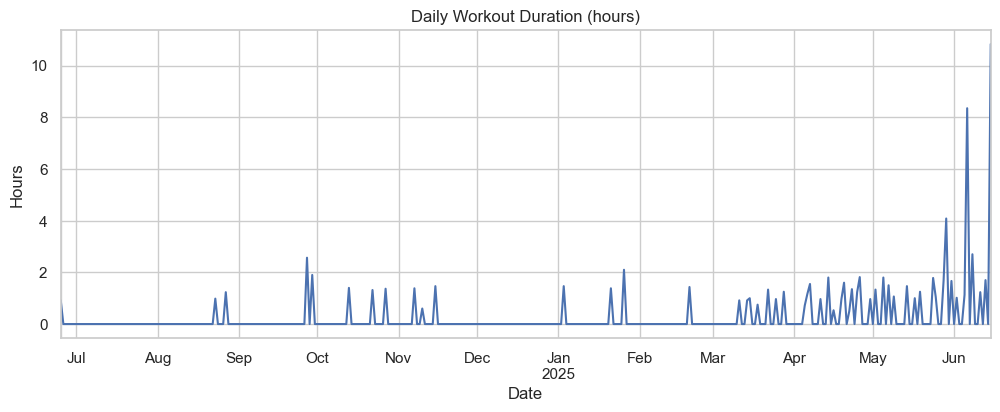

Summary statistics:
count    356.000000
mean       0.254120
std        0.887183
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       10.833333
Name: Workout_Duration_h, dtype: float64


In [17]:
# EDA: Plot time series and summary statistics
plt.figure(figsize=(12, 4))
ts.plot(title="Daily Workout Duration (hours)")
plt.ylabel("Hours")
plt.grid(True)
plt.show()

# Summary stats
print("Summary statistics:")
print(ts.describe())

In [18]:
# Full time series with zeros for missing days
ts = daily_ts.reindex(pd.date_range(daily_ts.index.min(), daily_ts.index.max(), freq="D"), fill_value=0)
ts.index.name = "Date"

# Filtered version without zero-duration days
ts_nonzero = ts[ts > 0]

ts_nonzero.head()

Date
2024-06-25    0.916667
2024-08-23    0.983333
2024-08-27    1.233333
2024-09-27    2.566667
2024-09-29    1.900000
Name: Workout_Duration_h, dtype: float64

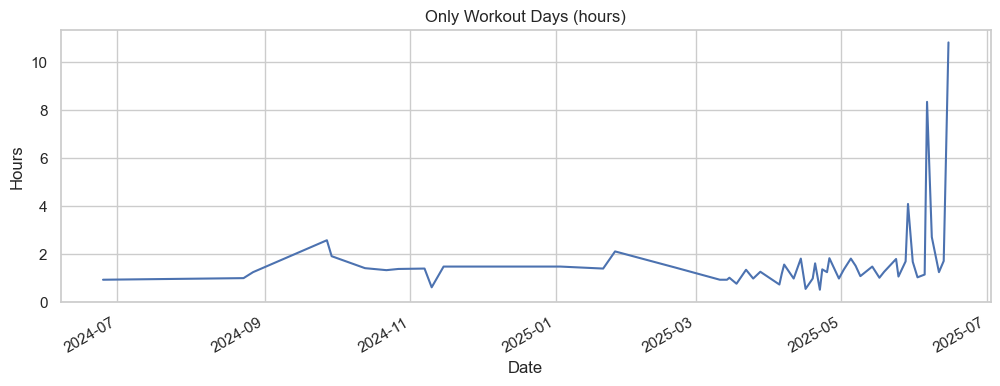

Summary statistics:
count    54.000000
mean      1.675309
std       1.687066
min       0.500000
25%       1.000000
50%       1.333333
75%       1.650000
max      10.833333
Name: Workout_Duration_h, dtype: float64


In [19]:
# EDA: Plot time series and summary statistics
plt.figure(figsize=(12, 4))
ts_nonzero.plot(title="Only Workout Days (hours)")
plt.ylabel("Hours")
plt.grid(True)
plt.show()

# Summary stats
print("Summary statistics:")
print(ts_nonzero.describe())

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


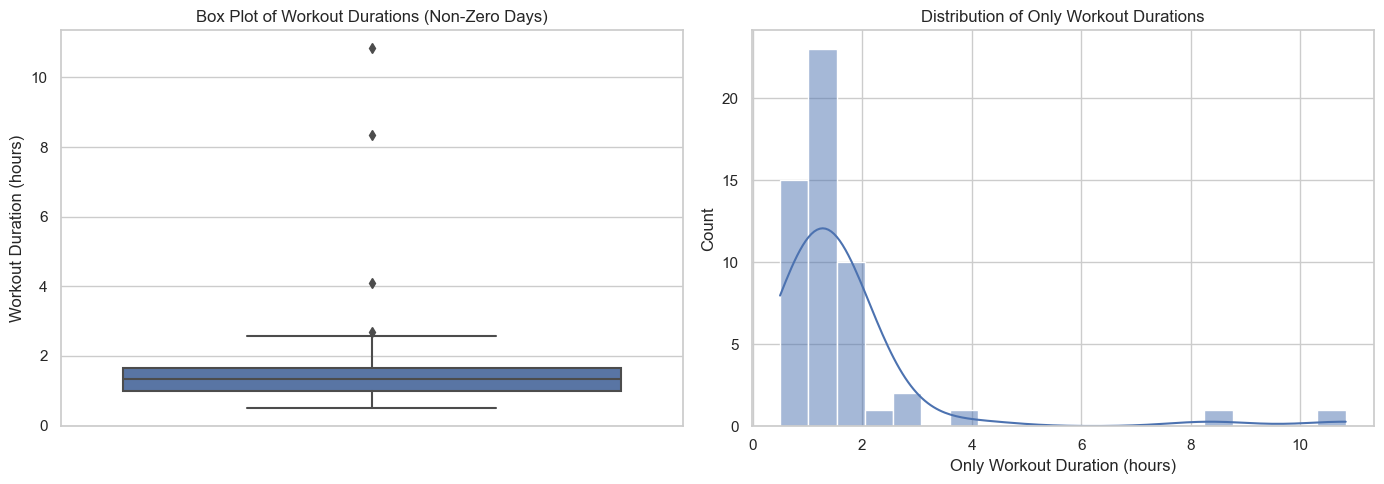

In [20]:
# Filter non-zero workout durations
ts_nonzero = ts[ts > 0]

# Set plot style
sns.set(style="whitegrid")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
sns.boxplot(y=ts_nonzero.values, ax=ax[0])
ax[0].set_title("Box Plot of Workout Durations (Non-Zero Days)")
ax[0].set_ylabel("Workout Duration (hours)")

# Distribution plot
sns.histplot(ts_nonzero.values, kde=True, ax=ax[1], bins=20)
ax[1].set_title("Distribution of Only Workout Durations")
ax[1].set_xlabel("Only Workout Duration (hours)")

plt.tight_layout()
plt.show()


In [40]:
# Convert the 'Datum' column to datetime
df['Datum'] = pd.to_datetime(df['Datum'], format="%d.%m.%Y")

# Extract weekday names (e.g., Monday, Tuesday)
df['Wochentag'] = df['Datum'].dt.day_name()

# Count visits per weekday
wochentag_counts = df['Wochentag'].value_counts().sort_index()

# Count total distinct workout days
total_days = df['Datum'].nunique()

# Add total to the result
wochentag_counts['TOTAL'] = total_days

# Display as DataFrame
result_df = wochentag_counts.reset_index(name='Anzahl der Besuche')
result_df = result_df.rename(columns={'index': 'Wochentag'})

# Show result
print(result_df)


   Wochentag  Anzahl der Besuche
0     Friday                  12
1     Monday                   5
2   Saturday                   8
3     Sunday                  11
4   Thursday                   4
5    Tuesday                   8
6  Wednesday                   7
7      TOTAL                  54


ADF Statistic: 1.8155409151879192
p-value: 0.998379347030332
Critical Value (1%): -3.568485864
Critical Value (5%): -2.92135992
Critical Value (10%): -2.5986616


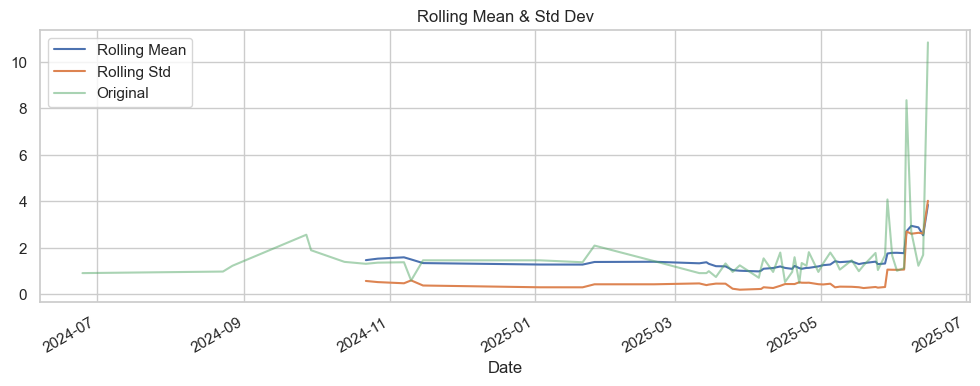

In [21]:
# ADF Test
adf_result = adfuller(ts_nonzero)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

# Rolling mean and std
ts_nonzero.rolling(7).mean().plot(label="Rolling Mean", figsize=(12, 4))
ts_nonzero.rolling(7).std().plot(label="Rolling Std")
ts_nonzero.plot(alpha=0.5, label="Original")
plt.legend()
plt.title("Rolling Mean & Std Dev")
plt.grid(True)
plt.show()

ADF Statistic (1st diff): -16.000480081360166
p-value: 6.519733397378038e-29
Critical Value (1%): -3.568485864
Critical Value (5%): -2.92135992
Critical Value (10%): -2.5986616


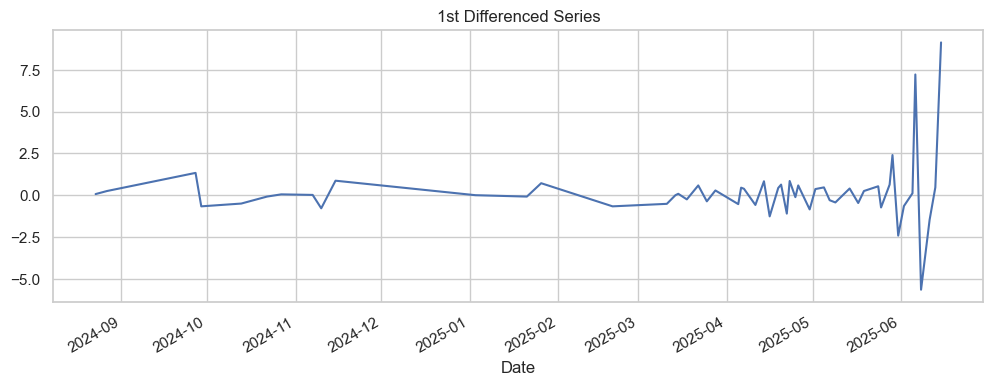

In [22]:
# First difference
ts_diff = ts_nonzero.diff().dropna()

# ADF Test on differenced data
adf_result_diff = adfuller(ts_diff)
print(f"ADF Statistic (1st diff): {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")
for key, value in adf_result_diff[4].items():
    print(f"Critical Value ({key}): {value}")

# Plot differenced series
ts_diff.plot(title="1st Differenced Series", figsize=(12, 4))
plt.grid(True)
plt.show()

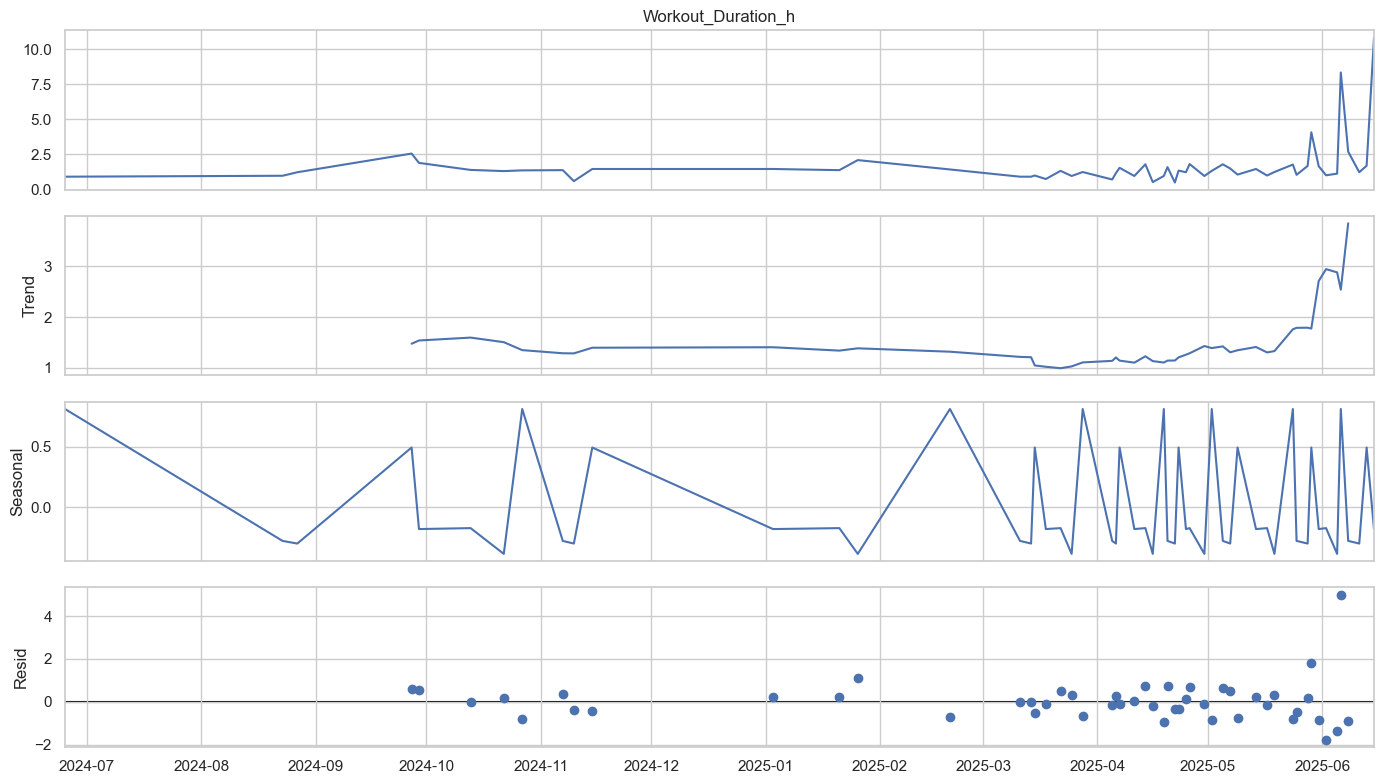

In [42]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(ts_nonzero, model='additive', period=7)

# Plot all components with wider horizontal layout
fig = decomposition.plot()
fig.set_size_inches(14, 8)  # width = 14 inches, height = 8 inches
plt.tight_layout()
plt.show()


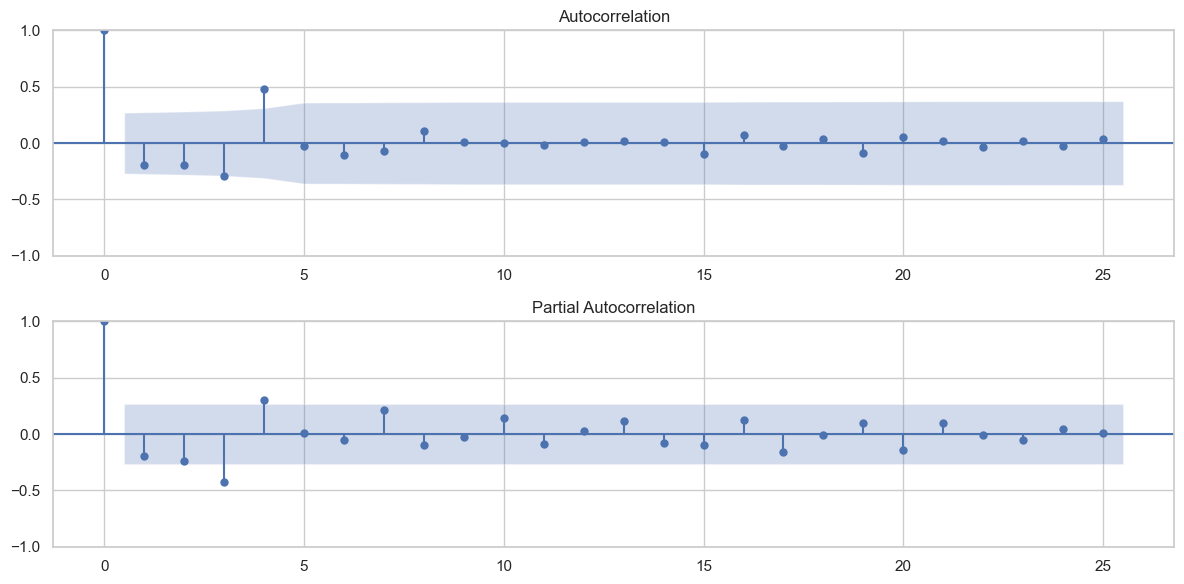

In [24]:
# Ensure valid lag count (must be strictly less than n//2)
valid_lags = min(30, len(ts_diff) // 2 - 1)

# ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(ts_diff, ax=ax[0], lags=valid_lags)
plot_pacf(ts_diff, ax=ax[1], lags=valid_lags)
plt.tight_layout()
plt.show()
